# PySCF graphene example

Based on: https://github.com/pyscf/pyscf/tree/master/examples

In [1]:
from ase import Atoms
from ase.build import  bulk, graphene
from ase.io import read, write
from ase.visualize import view

graph=graphene(size=(15,15,1))

view(graph, viewer='x3d')

In [2]:
import time
from pyscf.pbc import df as pdf
from pyscf.pbc import gto as pbcgto
from pyscf.pbc import scf as pbchf

nk = 1
kpts = [nk,nk,1]
Lz = 25 # Smallest Lz value for ~1e-6 convergence in absolute energy
a = 1.42 # bond length in graphene
fft_ke_cut = 300
# Much smaller mesh needed for AFTDF with the setting cell.low_dim_ft_type='inf_vacuum'
aft_mesh = [30,30,40]
e = []
t = []
pseudo = 'gth-pade'

##################################################
#
# 2D PBC with FFT
#
##################################################
cell = pbcgto.Cell()
cell.build(unit = 'B',
           a = [[4.6298286730500005, 0.0, 0.0], [-2.3149143365249993, 4.009549246030899, 0.0], [0.0, 0.0, Lz]],
           atom = 'C 0 0 0; C 0 2.67303283 0',
           ke_cutoff = fft_ke_cut,
           dimension=2,
           pseudo = pseudo,
           verbose = 7,
           precision = 1e-6,
           basis='gth-szv')
t0 = time.time()
mf = pbchf.KRHF(cell, exxdiv='ewald')
mf.with_df = pdf.FFTDF(cell)
mf.kpts = cell.make_kpts(kpts)
mf.conv_tol = 1e-6
e.append(mf.kernel())
t.append(time.time() - t0)

System: uname_result(system='Linux', node='17a157c8ffb4', release='5.10.43.3-microsoft-standard-WSL2', version='#1 SMP Wed Jun 16 23:47:55 UTC 2021', machine='x86_64', processor='x86_64')  Threads 12
Python 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
[GCC 7.3.0]
numpy 1.18.4  scipy 1.4.1
Date: Wed Aug  4 20:15:44 2021
PySCF version 1.7.6a1
PySCF path  /opt/conda/lib/python3.7/site-packages/pyscf

[CONFIG] DEBUG = False
[CONFIG] MAX_MEMORY = 4000
[CONFIG] TMPDIR = .
[CONFIG] UNIT = angstrom
[CONFIG] VERBOSE = 3
[CONFIG] conf_file = None
[INPUT] verbose = 7
[INPUT] max_memory = 4000 
[INPUT] num. atoms = 2
[INPUT] num. electrons = 8
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = B
[INPUT]  1 C      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.000000000000 Bohr
[INPUT]  2 C      0.000000000000   1.414508057677   0.000000000000 AA    0.000000000000  

In [3]:
from ase.lattice import bulk
from ase.dft.kpoints import sc_special_points as special_points, get_bandpath

In [4]:
points = special_points['hexagonal']
G = points['G']
M = points['M']
K = points['K']
band_kpts, kpath, sp_points = get_bandpath([G, M, K, G], cell.a, npoints=50)
band_kpts = cell.get_abs_kpts(band_kpts)

/opt/conda/lib/python3.7/site-packages/ase/dft/kpoints.py:357: UserWarning: Please do not use (kpts, x, X) = bandpath(...).  Use path = bandpath(...) and then kpts = path.kpts and (x, X, labels) = path.get_linear_kpoint_axis().
  warnings.warn('Please do not use (kpts, x, X) = bandpath(...).  '


In [5]:
e_kn_2 = mf.get_bands(band_kpts)[0]
vbmax = -99
for en in e_kn_2:
    vb_k = en[cell.nelectron//2-1]
    if vb_k > vbmax:
        vbmax = vb_k
e_kn_2 = [en - vbmax for en in e_kn_2]

au2ev = 27.21139

emin = -1*au2ev
emax = 1*au2ev

fft_jk: get_k_kpts max_memory 2322.638848  blksize 6
    CPU time for get_k_kpts: make_kpt (0,*)   1284.12 sec, wall time    125.61 sec
Monkhorst pack size [1 1 1] ew_eta 1.0978687634728737 ew_cut 5.4194174107570205
Ewald components = 4.24875213041003e-13, -0.619406120453851, 0.164376039031296
    CPU time for vj and vk   1328.54 sec, wall time    129.87 sec


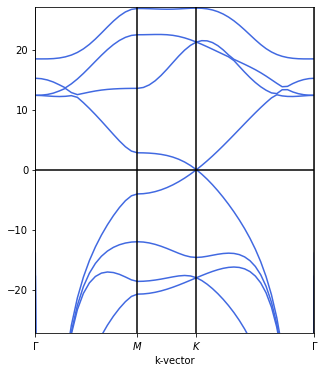

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 6))
nbands = cell.nao_nr()
for n in range(nbands):
    plt.plot(kpath, [e[n]*au2ev for e in e_kn_2], color='#4169E1')
for p in sp_points:
    plt.plot([p, p], [emin, emax], 'k-')
plt.plot([0, sp_points[-1]], [0, 0], 'k-')
plt.xticks(sp_points, ['$%s$' % n for n in [r'\Gamma', 'M', 'K', r'\Gamma']])
plt.axis(xmin=0, xmax=sp_points[-1], ymin=emin, ymax=emax)
plt.xlabel('k-vector')

plt.show()